In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.font_manager
import plotly.express as px

# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'NEXON' in f.name]
# print ('캐시 위치: ', matplotlib.get_cachedir())

plt.style.use('seaborn-dark')
plt.rcParams["font.family"] = 'NEXON Lv2 Gothic'
plt.rcParams["font.weight"] = 'light'

plt.rcParams['axes.unicode_minus'] = False

In [18]:
station = pd.read_csv(
    "assets/seoul_bike_station_01_12.csv", encoding="CP949", index_col=0
)

near_bus = pd.read_csv(
    "assets/near_bus_500m.csv", encoding="CP949", index_col=0
)

seoul_bike = pd.read_parquet("/Users/yangwoolee/git_repo/seoulBikeProject/parquet/220607_bike_record.parquet.gzip")

sub_info = pd.read_csv(
    "assets/sub_and_bike_info.csv", encoding="CP949", index_col=0
)

search_info = pd.read_csv(
    "assets/search_info.csv", encoding="CP949", index_col=0
)
btstation = pd.read_csv(
    "assets/btbtstation_info.csv", encoding="CP949", index_col=0
)

near_sub = pd.read_csv(
    "assets/near_sub_station.csv", encoding="CP949", index_col=0
)

In [206]:
def haversine_np(
    lon1: float, lat1: float, lon2: float, lat2: float
) -> np.array:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    )

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

def raw_data( val: int) -> pd.DataFrame:
    quert_st_id1 = seoul_bike[seoul_bike["st_id1"] == val]
    quert_st_id2 = seoul_bike[seoul_bike["st_id2"] == val]
    filtered_data = pd.concat(
        [quert_st_id1, quert_st_id2], axis=0
    ).drop_duplicates()
    filtered_data.drop(columns="index", inplace=True)
    bm = (filtered_data["st_id1"] == val) & (filtered_data["st_id2"] == val)
    filtered_data = filtered_data[~bm]

    # # 반납
    # filtered_data_end = filtered_data[
    #     (filtered_data["st_id2"] == val) & (filtered_data["st_id1"] != val)
    # ]

    return filtered_data

# def findInteractionNum(id:int) :
def stationInteraction(id:int) :
    stationInteraction = seoul_bike[seoul_bike["st_id1"] == id ].groupby(by='st_id2').size()
    data = stationInteraction[stationInteraction>=10].sort_values(ascending=False)
    result = pd.DataFrame(data).reset_index(drop=False)
    result['st_id1']= id
    result = result[['st_id1','st_id2',0]]
    return result

def drawMap(ids:list) : 
    if type(ids) == str :
        ids = [ids]

    stationInfo = station[station.index.isin(ids)]
    fig = px.scatter_mapbox(
    stationInfo,
    lat="latitude",
    lon="longtitude",
    hover_data={'latitude':False,'longtitude':False,'st_name':True},
    opacity=0.8,
    zoom=10,
    # marker=14,
    custom_data=["st_name"],
    color=["도착", "출발"],
    color_discrete_sequence=["#35C768", "#3581C7"],  # 대여소 # 자하철
)
    fig.update_traces(marker={'size': 15})

    fig.update_layout(
                margin=dict(l=0, r=0, t=0, b=0),
                mapbox_zoom=14,
                mapbox_center={"lat": stationInfo.iloc[0]['latitude'], "lon": stationInfo.iloc[0]['longtitude']},
                mapbox=dict(
                    accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA",
                    style="mapbox://styles/yangoos/cl4cljdka001o14n3cll7whrh/draft",
                ),
                legend=dict(
                    yanchor="top",
                    y=0.82,
                    xanchor="right",
                    x=0.95,
                    bgcolor="rgba(223, 235, 223, 0.8)",
                    # title={"text": None},
                ))
    return fig
    

Text(0.5, 1.0, '대여소 거리 별 대여건수')

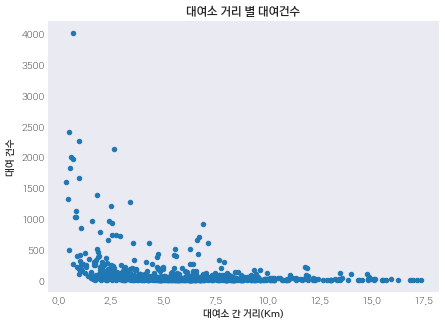

In [20]:

def haversineOneStation(id:int,station) -> pd.DataFrame :
    '''
    선택한 대여소를 기준으로 이용기록이 있는 대여소의 직선 거리와 대여 건수를 계산한다. 

    '''
    # st_id2 선정
    stationInteraction = seoul_bike[seoul_bike["st_id1"] == id ].groupby(by='st_id2').size()
    
    # 대여기록 10건 이상인 대여소만 수집
    data = stationInteraction[stationInteraction>=10].sort_values(ascending=False)

    # dep & arr station info
    dep = station[station.index.isin([id])]
    arr = station[station.index.isin(data.index.tolist())]

    # haversine으로 거리 구하기
    depLong = dep['longtitude'].values
    depLat = dep['latitude'].values
    arrLong=arr['longtitude']
    arrLat=arr['latitude']
    dist = haversine_np(depLong,depLat,arrLong,arrLat)
    dist = pd.DataFrame(dist/1000,columns=['dist']).reset_index(drop=False)

    # 결과종합
    result = pd.DataFrame(data,columns=['count']).reset_index(drop=False)
    result['st_id1']= id
    result = result[['st_id1','st_id2','count']]
    result = pd.merge(left=result, right=dist, left_on='st_id2',right_on='st_id')

    return result.drop(columns='st_id')

#예시
dist = haversineOneStation(207,station)

# 대여소 거리에 따른 대여기록 
plt.rcParams["font.family"] = 'NEXON Lv2 Gothic'
dist.query("count <30000").plot.scatter(x='dist',y='count',figsize=(7,5))
plt.xlabel(xlabel='대여소 간 거리(Km)')
plt.ylabel(ylabel='대여 건수')
plt.title('대여소 거리 별 대여건수')

### Log로 그려보기

Text(0, 0.5, '대여건수(Log)')

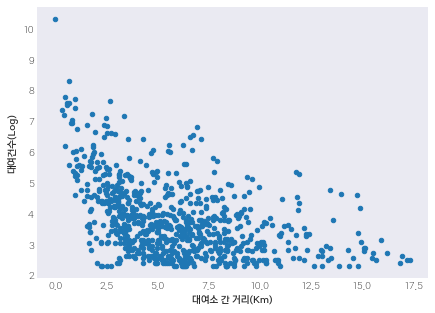

In [21]:
copydist = dist.copy()
copydist['log'] =  np.log(dist['count'])
copydist.plot.scatter('dist','log',figsize=(7,5))
plt.xlabel(xlabel='대여소 간 거리(Km)')
plt.ylabel(ylabel='대여건수(Log)')

### 전체 대여소의 대여소 거리 및 count 종합

In [22]:
totalList = list(map(lambda x : haversineOneStation(x,station),station.index))
totalDataFrame = pd.concat(totalList)
totalDataFrame.head(3)

,st_id1,st_id2,count,dist
0,102,102,3100,0.000000
1,102,107,1990,0.723829
2,102,152,1925,1.116089


In [26]:
k['dist'].max()

21.33590531354898

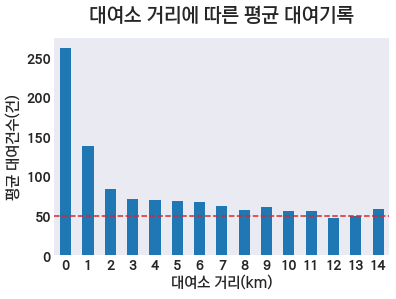

In [28]:
# 30건 이상 대여기록만 포함
k =totalDataFrame[['dist','count']].query('dist > 0 & count >30').reset_index(drop=True)

# 15개 범위로 자르기
bins = list(range(0,15))
bins.append(int(k['dist'].max()))
k['cat'] = pd.cut(k['dist'], bins=bins)

# 대여소 간 직선거리에 따른 평균 대여기록
x = k.groupby(by='cat')['count'].mean()
kkk = pd.DataFrame(x).reset_index(drop=False)
kkk.plot.bar(rot=0)

# x,y labels and ticks

plt.title(label='대여소 거리에 따른 평균 대여기록',fontdict={'size': 20},y=1.05)
plt.xlabel(xlabel='대여소 거리(km)',fontdict={'size':15})
plt.ylabel(ylabel='평균 대여건수(건)',fontdict={'size':15})
plt.xticks(fontsize=13,weight='bold')
plt.yticks(fontsize=13,weight='bold')

# red dot line
avg = int(np.mean(totalDataFrame.query('dist >= 2')['count']))
plt.axhline(y=50, color='tab:red',linestyle='--')

# off some fetures
plt.legend().remove()
plt.grid(False)

In [62]:
# bins = list(range(0,15))
# bins.append(int(k['dist'].max()/1000))
# kkkk = pd.cut(k['dist']/1000, bins, right=False)
# kkkk.values.describe()


### A->B, B->A 대여소 이동 비율 계산

In [31]:
### Save File로 대체

# wholeCount= list(map(stationInteraction,station.index))
# c = pd.concat(wholeCount)

# # st_id == st_id2 and st_id2 == st_id1
# def findId1AndId2(id1,id2,c) : 
    
#     test1 = np.in1d(c['st_id1'],np.array([id1])) 
#     test2 = np.in1d(c['st_id2'],np.array([id2]))
#     val1 = c[test1 & test2][0].values[0]
    
#     # id2 to id1은 없을 수 있으니 try Execpt 활용 
#     try : 
#         test3 = np.in1d(c['st_id1'],np.array([id2])) 
#         test4 = np.in1d(c['st_id2'],np.array([id1]))
#         val2 = c[test3 & test4][0].values[0]
#     except :
#         # 최소 대여기준이 10건이므로 그 절반인 5를 기본 값으로 넣음
#         val2 = 5

#     result = [id1,id2,val1,val2]
#     return result

# findId1AndId2(103,101,c)
# # return id1, id2, 1->2 ,2->1


In [ ]:
### Save File로 대체

# # st_id1, st_id2 추출
# newC = c[~(c['st_id1'] == c['st_id2'])]
# st_id1 = newC[newC['st_id1'] > newC['st_id2']]['st_id1'].tolist()
# st_id2 = newC[newC['st_id1'] > newC['st_id2']]['st_id2'].tolist()

# # 전체 대여소에 적용
# k = [findId1AndId2(a,b,c) for a, b in zip(st_id1,st_id2)]

# # 결과 dataframe으로
# j = pd.DataFrame(k)
# j.columns = ['st_id1','st_id2','1to2','2to1']

# # 에러 제거
# BM=(j['st_id1'].isin([3,5]) | j['st_id2'].isin([3,5]))
# j = j[~BM]

# # 비율 계산
# j['1to2Rate']= j['1to2']/j['2to1']
# j['2to1Rate']= j['2to1']/j['1to2']

In [178]:
j = pd.read_csv('./assets/saveForBikeRate.csv',encoding='cp949',index_col=0)
j['2to1']=j['2to1'].replace(5,10)
j['1to2Rate']= j['1to2']/j['2to1']
j['2to1Rate']= j['2to1']/j['1to2']
j.head(2)

,st_id1,st_id2,1to2,2to1,1to2Rate,2to1Rate
0,102,101,67,41,1.634146,0.611940
1,103,102,684,813,0.841328,1.188596


In [225]:
# 1to2 비율체크
jjk = j.sort_values(by='1to2Rate',ascending=False).head(50)

# #2to1 비율체크
# jjk = j.sort_values(by='2to1Rate',ascending=False).head(5)
jjk.head(5)

,st_id1,st_id2,1to2,2to1,1to2Rate,2to1Rate
63410,2092,2026,505,12,42.083333,0.023762
46345,1550,1531,291,10,29.100000,0.034364
94292,3310,2169,1666,66,25.242424,0.039616
27351,975,912,274,11,24.909091,0.040146
19869,762,736,235,10,23.500000,0.042553


In [231]:
#1to2 체크중
a = jjk[['st_id1','st_id2']].values.tolist()
find = a[26]
kb = btstation[(btstation['value'].isin(find))].sort_values(by='value',ascending=False)
print(f'출발 대여소 : {kb.label.values[0]} ||  id : {kb.value.values[0]}')
print(f'도착 대여소 : {kb.label.values[1]} ||  id : {kb.value.values[1]}')
print('')
id1 = kb.value.values[0]
id2 = kb.value.values[1]
print(f'전체 대여기록 {len(seoul_bike[(seoul_bike["st_id1"] == id1) & (seoul_bike["st_id2"] == id2)])} 건')
print(seoul_bike[(seoul_bike["st_id1"] == id1) & (seoul_bike["st_id2"] == id2)]['date'].dt.hour.value_counts().head(5))

# drawMap(find)

출발 대여소 : 금호역 1번출구 앞 ||  id : 522
도착 대여소 : 을지로3가역 3번출구 ||  id : 398

전체 대여기록 154 건
3     152
20      2
Name: date, dtype: int64


In [82]:
#log2로 변환
newj = j.copy()
newj['1to2Rate'] = np.log2(newj['1to2Rate'])
newj['2to1Rate'] = np.log2(newj['2to1Rate'])

newj.head(2)

,st_id1,st_id2,1to2,2to1,1to2Rate,2to1Rate
0,102,101,67,41,0.708537,-0.708537
1,103,102,684,813,-0.249259,0.249259


In [ ]:
test1 = np.abs(newj['1to2Rate'])
# test2= pd.cut(test1,bins=[0,1,2,3,4,8],labels=['1~2배','2~4배','4~8배','8~16배','16배~'])

test1 = newj['1to2Rate']
test2= pd.cut(test1,10)
# test2 = test2.fillna(0)

<AxesSubplot:xlabel='categories'>

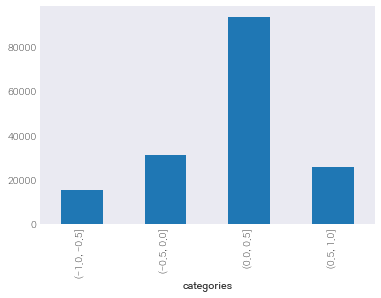

In [173]:
test2= pd.cut(test1,bins=[-6,-2,-1,1,2,6])
test2bar = test2.values.describe()
test2bar['counts'].plot.bar()

test3 = pd.cut(test1,bins=[-1,-0.5,0,0.5,1]).dropna()
test3bar = test3.values.describe()
test3bar['counts'].plot.bar()

In [ ]:
plt.figure(figsize=(6,5))
test2bar=test2.value_counts().sort_values(ascending=False)
plt.barh(y=test2bar.index,width=test2bar,)
plt.title(label='대여소 이동 비율 차이',fontdict={'size': 20},y=1.05)
plt.xlabel(xlabel='A->B/B->A',fontdict={'size':14})
plt.ylabel(ylabel='대여소(개)',fontdict={'size':14})
plt.xticks(fontsize=12,weight='bold')
plt.yticks(fontsize=12,weight='bold')

In [216]:
# stationInteraction(1830)